In [62]:
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
#這邊是先將資料載入後做統一格式的前處理
Data=pd.read_csv("0050 ETF Stock Price History.csv") #載入csv
Data #show data

,Date,Price,Open,High,Low,Vol.,Change %
0,11/03/2023,125.45,125.00,125.60,124.70,9.13M,0.76%
1,11/02/2023,124.50,123.15,124.50,123.15,10.20M,2.26%
2,11/01/2023,121.75,122.00,122.15,121.25,4.85M,0.50%
3,10/31/2023,121.15,122.40,122.45,121.10,11.95M,-0.70%
4,10/30/2023,122.00,122.40,122.85,121.75,9.79M,-0.25%
...,...,...,...,...,...,...,...
2397,01/08/2014,57.80,57.70,57.95,57.70,7.61M,0.17%
2398,01/07/2014,57.70,57.75,57.90,57.70,13.13M,0.00%
2399,01/06/2014,57.70,57.75,57.95,57.55,14.87M,-0.26%
2400,01/03/2014,57.85,58.45,58.45,57.70,14.51M,-1.20%


In [64]:
Data['Date'] = pd.to_datetime(Data['Date']) #將原始資料的時間轉為pandas的Time Series序列
Data.index=Data.Date
Data=Data.drop(['Date'],axis=1)
Data=Data.iloc[::-1] #因為原始資料的前後順序相反了 所以將資料倒過來
Data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-01-02,58.55,58.70,58.75,58.35,10.76M,-0.26%
2014-01-03,57.85,58.45,58.45,57.70,14.51M,-1.20%
2014-01-06,57.70,57.75,57.95,57.55,14.87M,-0.26%
2014-01-07,57.70,57.75,57.90,57.70,13.13M,0.00%
2014-01-08,57.80,57.70,57.95,57.70,7.61M,0.17%
...,...,...,...,...,...,...
2023-10-30,122.00,122.40,122.85,121.75,9.79M,-0.25%
2023-10-31,121.15,122.40,122.45,121.10,11.95M,-0.70%
2023-11-01,121.75,122.00,122.15,121.25,4.85M,0.50%


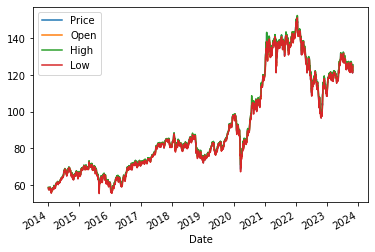

In [65]:
Data.plot()

In [66]:
#Data.Price.loc['2019'].plot()

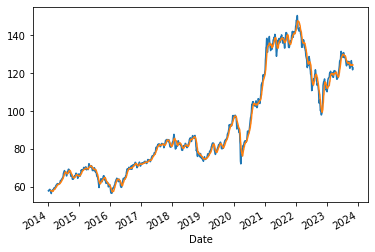

In [67]:
#要使用均線交叉策略 所以先定義兩條均線
fast=Data.Price.rolling(5).mean() #比較快的均線 參數為5
slow=Data.Price.rolling(20).mean() #比較慢的均線 參數為20
fast.plot()
slow.plot()

Date
2014-01-02    False
2014-01-03    False
2014-01-06    False
2014-01-07    False
2014-01-08    False
              ...  
2023-10-30    False
2023-10-31    False
2023-11-01    False
2023-11-02    False
2023-11-03    False
Name: Price, Length: 2402, dtype: bool

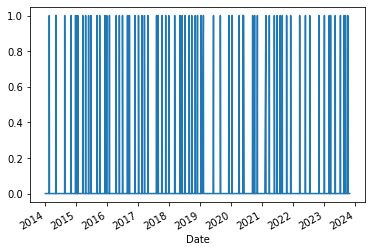

In [68]:
#這邊是使用判斷式來過濾出進場&出場時間點
Entry=(fast>slow) &(fast.shift()<slow.shift()) #定義進場:快線向上穿越慢線
Exit=(fast<slow) &(fast.shift()>slow.shift()) #定義出場:快線向下穿越慢線
Data['Entry']=Entry
Data['Exit']=Exit
Entry.astype(int).plot()
Entry

In [69]:
Data

,Price,Open,High,Low,Vol.,Change %,Entry,Exit
Date,,,,,,,,
2014-01-02,58.55,58.70,58.75,58.35,10.76M,-0.26%,False,False
2014-01-03,57.85,58.45,58.45,57.70,14.51M,-1.20%,False,False
2014-01-06,57.70,57.75,57.95,57.55,14.87M,-0.26%,False,False
2014-01-07,57.70,57.75,57.90,57.70,13.13M,0.00%,False,False
2014-01-08,57.80,57.70,57.95,57.70,7.61M,0.17%,False,False
...,...,...,...,...,...,...,...,...
2023-10-30,122.00,122.40,122.85,121.75,9.79M,-0.25%,False,False
2023-10-31,121.15,122.40,122.45,121.10,11.95M,-0.70%,False,False
2023-11-01,121.75,122.00,122.15,121.25,4.85M,0.50%,False,False


In [70]:
# 交易模型的回測函數
def Backtesting(Data):
    # 初始化總收益
    Gain = 0
    # 用來存放每次交易的收益的列表
    GainList = []

    # 從輸入的資料中選取進場點
    EntryList = Data[Data['Entry'] == True]
    # 從輸入的資料中選取出場點
    ExitList = Data[Data['Exit'] == True]
    # 迭代處理每次進場
    for i in range(len(EntryList)-1):
        # 購買價格為進場點的價格
        BuyPrice = EntryList.Price.values[i]
        # 進場時間
        Time = EntryList.index[i]
        # 賣出價格為進場後的第一個出場點的價格
        SellPrice = ExitList.loc[Time:].Price.values[0]

        # 計算該次交易的收益並加總到總收益
        Gain += (SellPrice - BuyPrice)
        # 將該次交易的收益加入收益列表
        GainList.append(Gain)

    # 將收益列表轉換為DataFrame格式
    GainList = pd.DataFrame(GainList)
    # 將列名設定為'Gain'
    GainList['Gain'] = GainList[0]
    # 刪除原來的列
    GainList = GainList.drop([0], axis=1)
    # 將索引設定為進場點的時間
    GainList.index = EntryList.index[0:-1]

    # 繪製收益曲線
    GainList.plot()

    # 返回總收益
    return Gain

40.6

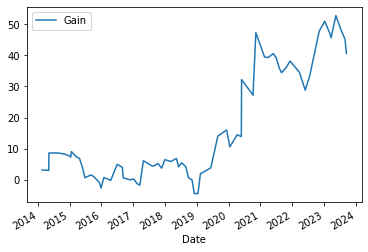

In [71]:
Backtesting(Data)

Date
2014-01-02    False
2014-01-03    False
2014-01-06    False
2014-01-07    False
2014-01-08    False
              ...  
2023-10-30    False
2023-10-31    False
2023-11-01    False
2023-11-02    False
2023-11-03    False
Name: Price, Length: 2402, dtype: bool

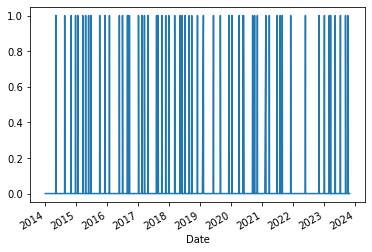

In [72]:
# 使用價格的30天中位數作為濾波器
Filter = Data.Price.rolling(30).median()

# 進場條件：價格高於濾波器
Entry = Entry & (Data.Price > Filter)

# 將進場條件以整數形式繪製
Entry.astype(int).plot()

# 將進場條件更新到資料框中
Data['Entry'] = Entry
Data['Exit'] = Exit

# 返回進場條件
Entry

40.14999999999999

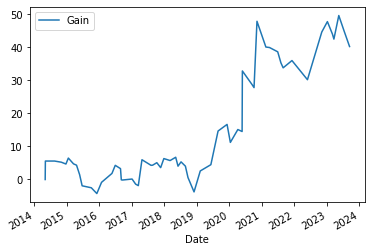

In [73]:
Backtesting(Data)